In [1]:
import copy
import glob
import os
import time
from collections import deque

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate


In [2]:
env_name = 'Gridworld-v0'
log_dir = '/tmp/gym'
device = torch.device("cpu")
alg = 'ppo'
log_interval = 10

value_loss_coef = 0.5
entropy_coef = 0.01
gamma = 0.99
lr = 7e-4
eps = 1e-5
alpha = 0.99
max_grad_norm = 0.5

clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1

num_env_steps = 10000
num_steps = 5
num_processes = 1

use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

env = gym.make(env_name)
envs = make_vec_envs(env_name, 0, 1, gamma, log_dir, device, False, capture_video=1, env_kwargs={})

actor_critic = Policy(
    envs.observation_space.shape,
    envs.action_space,
    base_kwargs={'recurrent': True})
actor_critic.to(device)

if alg == 'a2c':
        agent = algo.A2C_ACKTR(
            actor_critic,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            alpha=alpha,
            max_grad_norm=max_grad_norm)
elif alg == 'ppo':
    agent = algo.PPO(
        actor_critic,
        clip_param,
        ppo_epoch,
        num_mini_batch,
        value_loss_coef,
        entropy_coef,
        lr=lr,
        eps=eps,
        max_grad_norm=max_grad_norm)

global_step = 0

rollouts = RolloutStorage(num_steps, num_processes,
                          envs.observation_space.shape, envs.action_space,
                          actor_critic.recurrent_hidden_state_size)

obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

start = time.time()
num_updates = int(
    num_env_steps) // num_steps // num_processes
for j in range(num_updates):

    for step in range(num_steps):
        #Andy: add global step
        global_step += 1 * num_processes
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                rollouts.masks[step])

        # Obser reward and next obs
        obs, reward, done, infos = envs.step(action)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])

        # If done then clean the history of observations.
        masks = torch.FloatTensor(
            [[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor(
            [[0.0] if 'bad_transition' in info.keys() else [1.0]
             for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action,
                        action_log_prob, value, reward, masks, bad_masks)

    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
            rollouts.masks[-1]).detach()
        
    rollouts.compute_returns(next_value, use_gae, gamma,
                             gae_lambda, use_proper_time_limits)

    if alg == 'ppo':
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs = \
        agent.update(rollouts)

    else:
        value_loss, action_loss, dist_entropy = agent.update(rollouts)

    rollouts.after_update()

    if j % log_interval == 0 and len(episode_rewards) > 1:
        total_num_steps = (j + 1) * num_processes * num_steps
        end = time.time()
        print(
            "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
            .format(j, total_num_steps,
                    int(total_num_steps / (end - start)),
                    len(episode_rewards), np.mean(episode_rewards),
                    np.median(episode_rewards), np.min(episode_rewards),
                    np.max(episode_rewards), dist_entropy, value_loss,
                    action_loss))



C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Updates 80, num timesteps 405, FPS 75 
 Last 2 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 90, num timesteps 455, FPS 77 
 Last 2 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 100, num timesteps 505, FPS 78 
 Last 2 training episodes: mean/median reward -200.0/-200.0, min/max reward -200.0/-200.0

Updates 110, num timesteps 555, FPS 77 
 Last 3 training episodes: mean/median reward -170.0/-200.0, min/max reward -200.0/-110.0



KeyboardInterrupt: 

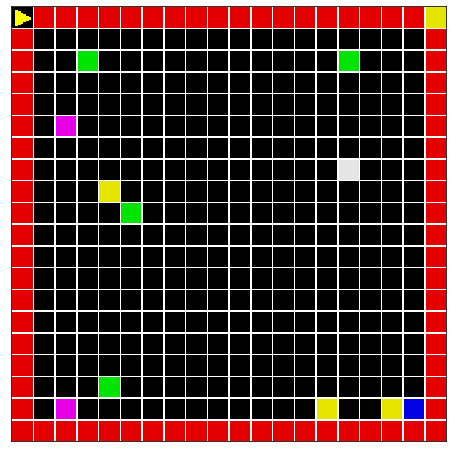

In [9]:
env.render('human')

In [10]:
img = env.render('rgb_array')

In [12]:
import matplotlib.pyplot as plt

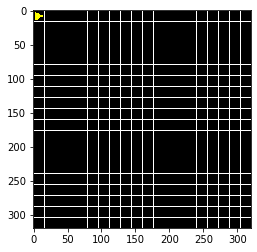

In [13]:
plt.imshow(img)

In [25]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from gym import spaces

class GridworldNav(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, view_width=2, max_steps=200, give_direction=0, world_gen_func={}, 
                world_size=[20, 20], give_dist=False, num_obstacles=10, goal_size=1,
                skeleton=True, goal_reward=10):
        '''
        General gridworld with 2d rays of vision. Agent gets to rotate or move forward
        '''
        super(GridworldNav, self).__init__()
        
        self.object_to_idx = {
            'wall': 1,
            'goal': 2
        }
        self.color_to_idx = {
            'invisible': 0,
            'red': 1,
            'green': 2,
            'blue': 3,
            'purple': 4,
            'yellow': 5,
            'white': 6
        }
        self.idx_to_rgb = {
            1: np.array([0.9, 0, 0]),
            2: np.array([0, 0.9, 0]),
            3: np.array([0, 0, 0.9]),
            4: np.array([0.9, 0, 0.9]),
            5: np.array([0.9, 0.9, 0]),
            6: np.array([0.9, 0.9, 0.9])
        }
        self.action_keys = {
            0: 'left',
            1: 'forward',
            2: 'right',
            3: 'nothing'
        }
        
        self.current_steps = 0
        
        #generate the character icon
        self.char_icon = np.zeros([15, 15, 3])
        self.char_icon[2:14, 2:4] = [1, 1, 0]
        self.char_icon[3:13, 4:6] = [1, 1, 0]
        self.char_icon[4:12, 6:8] = [1, 1, 0]
        self.char_icon[5:11, 8:10] = [1, 1, 0]
        self.char_icon[6:10, 10:12] = [1, 1, 0]
        self.char_icon[7:9, 12:14] = [1, 1, 0]
        
        # if skeleton is False:
        #convention of world:
        # first index is y position (down is +1, up is -1)
        # second index is x position (left is -1, right is +1)
        self.world_size = world_size
        self.objects = np.zeros(self.world_size)
        self.visible = np.zeros(self.world_size)
        self.obstacles = np.zeros(self.world_size)
        self.num_obstacles = num_obstacles
        # self.goal_size = goal_size
        self.goal_reward = goal_reward

        self.agent = [[0, 0], 0] #agent has a position and direction
        #direction is 0: right, 1: up, 2: left, 3: down
        self.view_width = view_width
        self.max_steps = max_steps
        self.give_direction = give_direction
        self.give_dist = give_dist

        total_width = view_width * 2 + 1
        if give_dist:
            self.observation_space = spaces.Box(0, 6, shape=(total_width * 2,))
        else:
            self.observation_space = spaces.Box(0, 6, shape=(total_width,))

        self.action_space = spaces.Discrete(4)

        self.generate_world()
        self.randomize_agent_pos()

        
    def step(self, action):
        collision = False
        done = False
        reward = -1
        
        if action == 0:
            self.agent[1] = (self.agent[1] + 1) % 4
        elif action == 2:
            self.agent[1] = (self.agent[1] - 1) % 4
        elif action == 1:
            pos = self.agent[0].copy()
            if self.agent[1] == 0:
                pos[1] += 1
            elif self.agent[1] == 1:
                pos[0] -= 1
            elif self.agent[1] == 2:
                pos[1] -= 1
            elif self.agent[1] == 3:
                pos[0] += 1
                
            if pos[0] < 0 or pos[0] >= self.world_size[0] or \
                pos[1] < 0 or pos[1] >= self.world_size[1]:
                #cannot walk off edge of world
                pass
            elif self.obstacles[pos[0], pos[1]] == 0:
                self.agent[0] = pos
            else:
                collision = pos
        
            #check if reaching a goal
            if self.objects[pos[0], pos[1]] == 2:
                reward = self.goal_reward
                done = True
        
        self.current_steps += 1

        if self.current_steps >= self.max_steps:
            done = True

        observation = self.get_observation()
        return observation, reward, done, {}
        
                
    def get_observation(self):
        '''
        Get observations based on vision lines. The agent sees to the left and right
        of where it is facing in a straight line. If the vision collides with an object (we assume
        it always does because there are walls, but without walls we would have to change it slightly)
        then we get a dist to the object and the color of the object
        '''
        #vision lines
        if self.agent[1] == 0:
            start = self.agent[0][1]
            end = self.world_size[1]
            left = self.agent[0][0] - self.view_width
            right = self.agent[0][0] + self.view_width
            left_idx = np.clip(left, 0, self.world_size[0])
            right_idx = np.clip(right, 0, self.world_size[0])
            left_right_idx = 0
            vis = self.visible[left_idx:right_idx+1, start:end] 
        elif self.agent[1] == 1:
            start = 0
            end = self.agent[0][0]
            left = self.agent[0][1] - self.view_width
            right = self.agent[0][1] + self.view_width
            left_idx = np.clip(left, 0, self.world_size[1])
            right_idx = np.clip(right, 0, self.world_size[1])
            left_right_idx = 1
            vis = np.rot90(self.visible[start:end+1, left_idx:right_idx+1], k=3)
        elif self.agent[1] == 2:
            start = 0
            end = self.agent[0][1]
            left = self.agent[0][0] + self.view_width
            right = self.agent[0][0] - self.view_width
            left_idx = np.clip(left, 0, self.world_size[0])
            right_idx = np.clip(right, 0, self.world_size[0])
            left_right_idx = 0
            vis = np.rot90(self.visible[right_idx:left_idx+1, start:end+1], k=2)
        elif self.agent[1] == 3:
            start = self.agent[0][0]
            end = self.world_size[0]
            left = self.agent[0][1] + self.view_width
            right = self.agent[0][1] - self.view_width
            left_idx = np.clip(left, 0, self.world_size[1])
            right_idx = np.clip(right, 0, self.world_size[1])
            left_right_idx = 1
            vis = np.rot90(self.visible[start:end, right_idx:left_idx+1], k=1)

        dists = np.argmax(vis > 0, axis=1)
        colors = vis[np.arange(vis.shape[0]), dists]

        if left < 0:
            dists = np.append([0]*-left, dists)
            colors = np.append([0]*-left, colors)
        if left >= self.world_size[left_right_idx]:
            dists = np.append([0]*(self.world_size[left_right_idx] + 1 - left), dists)
            colors = np.append([0]*(self.world_size[left_right_idx] + 1 - left), colors)
        if right < 0:
            dists = np.append(dists, [0]*-right)
            colors = np.append(colors, [0]*-right)
        if right >= self.world_size[left_right_idx]:
            dists = np.append(dists, [0]*(self.world_size[left_right_idx] + 1 - right))
            colors = np.append(colors, [0]*(self.world_size[left_right_idx] + 1 - right))
        
        if self.give_dist:
            return np.append(colors, dists)
        else:
            return colors


    def find_empty_space(self):
        '''
        Search for an empty space uniformly at random to populate with
        '''
        while True:
            y = np.random.randint(0, self.world_size[0])
            x = np.random.randint(0, self.world_size[1])
            if self.obstacles[y, x] == 0:
                return y, x

    
    def reset(self):
        self.current_steps = 0
        self.generate_world()
        self.randomize_agent_pos()
        return self.get_observation()
    
    def generate_world(self):
        '''
        Reset the world
        '''
        self.objects = np.zeros(self.world_size)
        self.visible = np.zeros(self.world_size)
        self.obstacles = np.zeros(self.world_size)
        
        self.generate_walls()
        
        #generate random obstacles
        for i in range(self.num_obstacles):
            y, x = self.find_empty_space()
            self.objects[y, x] = 1
            self.obstacles[y, x] = 1
            self.visible[y, x] = np.random.randint(1, 6)
            
        #generate a goal
        y, x = self.find_empty_space()
        self.objects[y, x] = 2
        self.obstacles[y, x] = 0
        self.visible[y, x] = 6
            
        


    
    
    def generate_walls(self):
        '''
        Set walls to red color
        '''
        #generate walls
        self.objects[:, 0] = self.object_to_idx['wall']
        self.objects[0, :] = self.object_to_idx['wall']
        self.objects[self.world_size[0]-1, :] = self.object_to_idx['wall']
        self.objects[:, self.world_size[1]-1] = self.object_to_idx['wall']
        
        #color walls red
        self.visible[:, 0] = self.color_to_idx['red']
        self.visible[0, :] = self.color_to_idx['red']
        self.visible[self.world_size[0]-1, :] = self.color_to_idx['red']
        self.visible[:, self.world_size[1]-1] = self.color_to_idx['red']
        
        self.visible[0, 0] = self.color_to_idx['green']
        self.visible[0, -1] = self.color_to_idx['yellow']
        
        #set walls as obstacles
        self.obstacles[:, 0] = 1
        self.obstacles[0, :] = 1
        self.obstacles[self.world_size[0]-1, :] = 1
        self.obstacles[:, self.world_size[1]-1] = 1
        
        
        
    def randomize_agent_pos(self, heading=True):
        '''
        Randomize position of agent to position that is not an obstacle
        '''
        y, x = self.find_empty_space()

        self.agent[0] = [y, x]
        self.agent[1] = np.random.randint(0, 4)
        
        
    def render(self, mode='rgb_array'):
        window_size = [(self.world_size[0]) * 16, (self.world_size[1]) * 16]
        
        img = np.zeros(window_size + [3])

        #draw grid
        img[np.arange(0, window_size[0], 16), :, :] = 1
        img[:, np.arange(0, window_size[1], 16), :] = 1
        
        def color_block(x, y, rgb, img):
            img[y*16+1:(y+1)*16, x*16+1:(x+1)*16] = rgb
            return img
        
        #draw solid objects
        for i in range(self.world_size[0]):
            for j in range(self.world_size[1]):
                if self.visible[i, j] != 0:
                    # print(i)
                    # img[i*16+1:(i+1)*16, j*16+1:(j+1)*16] = self.idx_to_rgb[self.visible[i, j]]
                    img = color_block(j, i, self.idx_to_rgb[self.visible[i, j]], img)
                    
        #draw agent
        y = self.agent[0][0]
        x = self.agent[0][1]
        img[y*16+1:(y+1)*16, x*16+1:(x+1)*16, :] = np.rot90(self.char_icon, k=self.agent[1])
        
        if mode == 'rgb_array':
            # return img.astype('uint8') * 255
            return img.astype('uint8')
        elif mode == 'human':
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            


In [26]:
env = GridworldNav()

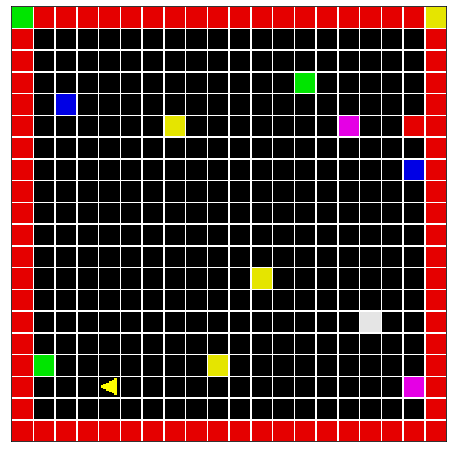

In [27]:
env.render('human')

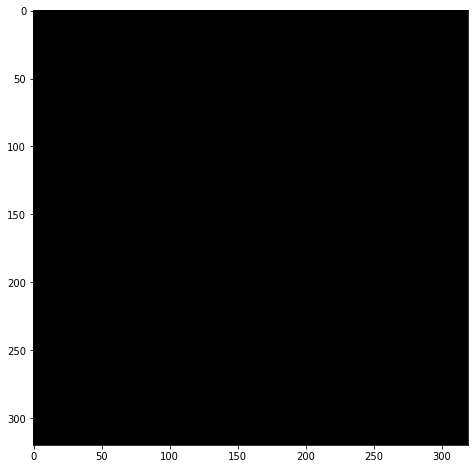

In [30]:
plt.figure(figsize=(8,8))
plt.imshow(env.render('rgb_array'))

In [29]:
env.render('rgb_array')

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [4]:
img = env.render('rgb_array')

In [7]:
env.reset()

array([1., 1., 1., 1., 4.])

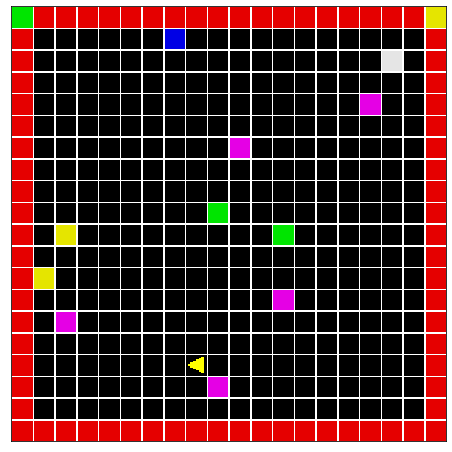

In [8]:
env.render('human')

In [5]:
img.astype('uint8')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [5]:
env.render('rgb_array').shape

(320, 320, 3)

In [21]:

obs

tensor([[nan, nan, nan, nan, nan]])

In [6]:
env2 = gym.make('NavEnv-v0')

pygame 2.0.1 (SDL 2.0.14, Python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
env2.reset()

array([0.        , 0.95658165, 0.        , 0.        , 0.96899061,
       0.        , 0.        , 0.97603581, 0.        , 0.        ,
       0.98041614, 0.        , 0.        , 0.98337007, 0.        ,
       0.        , 0.98546209, 0.        , 0.        , 0.9870404 ,
       0.        , 0.        , 0.98826549, 0.        , 0.        ,
       0.98924045, 0.        , 0.        , 0.98998788, 0.        ,
       0.        , 0.99060511, 0.        , 0.        , 0.99112619,
       0.        , 0.        , 0.9915399 , 0.        , 0.        ,
       0.99188256, 0.        , 0.        , 0.99216928, 0.        ,
       0.        , 0.99239276, 0.        , 0.        , 0.99257076,
       0.        , 0.        , 0.99270686, 0.        , 0.        ,
       0.99280499, 0.        , 0.        , 0.99286441, 0.        ,
       0.        , 0.99288931, 0.        , 0.        , 0.99287957,
       0.        , 0.        , 0.99283525, 0.        , 0.        ,
       0.99275405, 0.        , 0.        , 0.99263535, 0.     

In [9]:
env2.render('rgb_array').shape

(200, 300, 3)

In [24]:
env = gym.make('Gridworld-v0')

In [27]:
env.get_observation()

array([1., 1., 1., 1., 1.])

In [26]:
env.reset()

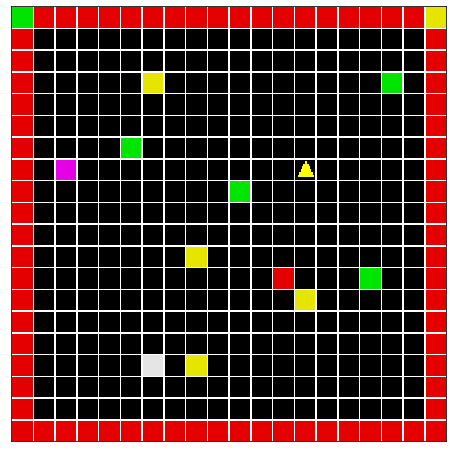

In [28]:
env.render('human')

In [30]:
envs.reset()

RuntimeError: Tried to reset an environment before done. If you want to allow early resets, wrap your env with Monitor(env, path, allow_early_resets=True)

In [22]:
recurrent_hidden_states

NameError: name 'recurrent_hidden_states' is not defined

In [20]:
actor_critic()

TypeError: forward() missing 3 required positional arguments: 'inputs', 'rnn_hxs', and 'masks'